# Memory considerations when training Neural Networks on GPUs

In this homework, we will train a ResNet model on CIFAR-10 using PyTorch and explore it's implications on GPU memory.

We will explore various systems considerations, such as the effect of batch size
on memory usage, the effect of different optimizers (SGD, SGD with momentum, Adam), and we will try to minimize the memory usage of training our model by applying gradient accumulation.


## Setup the environment

If you're running on colab - make sure you are using a GPU runtime. You can select a GPU runtime by clicking on `Runtime` -> `Change Runtime Type`.

> 💡 Hint - if you hit your colab GPU usage limit, try again in a few hours.

In [5]:
#@title Mount your Google Drive

# import os
# from google.colab import drive

# try:
#   drive.mount('/content/gdrive')

#   DRIVE_PATH = '/content/gdrive/My\ Drive/cs182hw4_sp25'
#   DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
#   if not os.path.exists(DRIVE_PYTHON_PATH):
#     %mkdir $DRIVE_PATH

#   ## the space in `My Drive` causes some issues,
#   ## make a symlink to avoid this
#   SYM_PATH = '/content/cs182hw4'
#   if os.path.isdir(SYM_PATH):
#     raise Exception(f"Path already exists - please delete {SYM_PATH} before mounting again.")
#   else:
#     !ln -sf $DRIVE_PATH $SYM_PATH
# except Exception as e:
#   print(e)
#   print("WARNING - Unable to mount google drive for storing logs. Storing logs in the runtime. Please keep downloading the logs to avoid losing data if the runtime terminates.")
#   os.makedirs('/content/cs182hw4/', exist_ok=True)

In [ ]:
#@title Install dependencies

# !pip install gputil --quiet

In [7]:
import gc
import GPUtil
import os
import subprocess
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import time


ROOT_PATH = '/content/cs182hw4/'

# Define the CSV format for logging memory usage. Used later in this notebook.
MEMORY_LOG_FMT = ['timestamp', 'memUsage']
TRAIN_LOG_FMT = ['timestamp', 'epoch', 'memUsage', 'loss', 'accuracy']

if torch.cuda.is_available():
  print("Using GPU.")
  device = torch.device("cuda:0")
else:
  print("!!! WARNING !!! - Could not find a GPU - please use a GPU for this homework! If you're on Colab, change your runtime to GPU.")
  device = torch.device("cpu")

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using GPU.


### Define helper functions and download CIFAR-10 dataset

In [8]:
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

def get_allocated_memory_str():
    return "Allocated memory: {:.2f} GB".format(torch.cuda.memory_allocated(device) / 1e9)

def run_nvidia_smi():
    if torch.cuda.is_available():
      print(subprocess.check_output("nvidia-smi", shell=True).decode("utf-8"))
    else:
      print("Running on CPU")

def get_gpu_memory_usage() -> float:
    # Use GPUtil python library to get GPU memory usage
    if torch.cuda.is_available():
      return GPUtil.getGPUs()[0].memoryUsed
    else:
      return 0

def cleanup_memory():
    gc.collect()
    torch.cuda.empty_cache()

# Define transformations for the input data. We resize the 32x32 inputs to 
# 224x224 which is the input shape for the ResNet family of models.
transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize to 224x224 for ResNet models
    transforms.ToTensor()
])

data_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
data_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


# We randomly subsample the dataset here to train our models faster for this notebook
SUBSAMPLE_SIZE = 1024*4
random_sample_idxs = torch.randint(len(data_train), (SUBSAMPLE_SIZE,))
subsampled_train_data = torch.utils.data.Subset(data_train, indices=random_sample_idxs)

Files already downloaded and verified
Files already downloaded and verified


# 1. Managing GPU memory when training deep models
One of the most common bottlenecks you will run into when training your deep learning models is the amount of GPU memory available to you. The exact memory usage of your training process depends on the specific model architecture and the size of the input data. The main components taking up GPU memory during training are:

* **Model Parameters**: The weights and biases of the model are stored in GPU memory during training. The number of parameters in a deep learning model can range from a few thousand to millions or even billions, depending on the model architecture and the size of the input data.

* **Activations**: The activations of each layer of the model are stored in GPU memory during the forward pass. The size of the activations can depend on the batch size and the number of hidden units in each layer. As the batch size increases, so does the size of the activations, which can quickly consume a large amount of GPU memory.

* **Gradients**: During the backward pass, the gradients of each layer with respect to the loss function are computed and stored in GPU memory. The size of the gradients can depend on the batch size and the number of hidden units in each layer. Like activations, larger batch sizes can lead to larger gradients and increased memory usage.

* **Input Data**: The input data, such as images or text, can also take up GPU memory during training. The size of the input data can depend on the input shape and the batch size.

* **Optimizer State**: The state of the optimizer, such as the momentum or running average of gradients, is stored in GPU memory during training. The size of the optimizer state can depend on the optimizer algorithm and the size of the model parameters.

## Let's analyze the ResNet-152 model and CIFAR-10 input sizes

We can count the number of parameters in the model by loading it and inspecting it. Once we know the number of parameters, we can estimate the model size by multiplying the number of parameters with the size of each parameter.

In [9]:
def analyze_model_and_inputs(model):
    print("Train data size: {}".format(len(data_train)))
    print("Test data size: {}".format(len(data_test)))
    
    # Fetch an example image to get image size
    image, label = data_train[0]
    print("Image input size: {}".format(image.size()))

    # Get model parameter count
    print("Model parameters: {}".format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

    # Get model size in MB
    print("Model size estimate (MB): {}".format(sum(p.numel() * p.element_size() for p in model.parameters()) / 1e6))

In [10]:
model = torchvision.models.resnet152(weights=None, num_classes=10)
model.to(device)  # Load the model into GPU memory
analyze_model_and_inputs(model)

Train data size: 50000
Test data size: 10000
Image input size: torch.Size([3, 224, 224])
Model parameters: 58164298
Model size estimate (MB): 232.657192


## Let's get to know our GPU better

Now that we have loaded the model onto the GPU, we will now use the `nvidia-smi` utility to measure the GPU memory utilization.

In [11]:
!nvidia-smi

Sun Mar  2 10:36:05 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.97       Driver Version: 528.97       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   45C    P4     6W /  25W |   1365MiB /  8188MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [12]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total Parameters:", total_params)
print(f"Size of the model: {total_params / (1000 ** 2):.2f}MB")

Total Parameters: 58164298
Size of the model: 58.16MB


In [13]:
get_allocated_memory_str()

'Allocated memory: 0.23 GB'

In [14]:
get_gpu_memory_usage()

1365.0

In [15]:
after_load = torch.cuda.memory_reserved(device) / 1e6
model_size_mb = (total_params * 4) / (1024 ** 2)

cuda_context_overhead = after_load - model_size_mb
print(f"CUDA Context Overhead: {cuda_context_overhead:.3f} MB")

CUDA Context Overhead: 33.973 MB


Note that the actual memory usage on the GPU is anywhere between ~500-1000 MB larger than the model size computed above. Why? In addition to loading the model, the GPU also needs to be initialized with essential kernels, memory allocation tables, and other GPU related state necessary to using the GPU. This is called the CUDA context.

The CUDA context can be considered a fixed memory overhead for using a Nvidia GPU.

# Questions (answer in written submission)
**Q1a. How many trainable parameters does ResNet-152 have? What is the estimated size of the model in MB?**

<span style="color:skyblue">Answer:</span>
As the code shown above, the total number of parameters in ResNet-152 is **58,164,298**. The estimated size of the model is **58.16MB**.

**Q1b. Which GPU are you using? How much total memory does it have?**

<span style="color:skyblue">Answer:</span>
I am using my local GPU, with total memory of **0.23 GB**.

**Q1c. After you load the model into memory, what is the memory overhead (size) of the CUDA context loaded with the model?**

> Hint - CUDA context size in this example is roughly (total GPU memory utilization - model size) 

<span style="color:skyblue">Answer:</span>
The memory overhead is about 33.973 MB.

# 2. Optimizer memory usage

The choice of optimizer affects the memory used to train your model. Different optimizers have different memory requirements for storing the gradients and the optimizer state. For example, the Adam optimizer stores a moving average of the gradients and the squared gradients for each parameter, which requires more memory than SGD.

Let's compare the memory usage of three different optimizers - SGD, SGD with momentum and ADAM.

Below we define a simple function to profile the memory usage for a given optimizer.


In [16]:
# Training function
def train_model(model, train_loader, criterion, optimizer, epochs=10, memory_log_path=None):
    os.makedirs(os.path.dirname(memory_log_path), exist_ok=True)
    with open(memory_log_path, 'w') as f:
      f.write(",".join(MEMORY_LOG_FMT) + "\n")
    for epoch in range(epochs):
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            with torch.set_grad_enabled(True):
              # Zero all gradients
              optimizer.zero_grad()

              # Get outputs
              outputs = model(images)

              # Compute loss
              loss = criterion(outputs, labels)
              loss.backward()

              # Run optimizer update step
              optimizer.step()

              # Print stats every 100 iterations
              if i % 100 == 0:
                  gpu_memory_usage = get_gpu_memory_usage()
                  print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, GPU Mem: {}'.format(epoch+1, epochs, i+1, len(train_loader), loss.item(), gpu_memory_usage))
                  memory_log = [str(time.time()), str(gpu_memory_usage)]
                  with open(memory_log_path, 'a') as f:
                    f.write(",".join(memory_log) + "\n") 
            del loss, outputs, images, labels  # To get accurate memory usage info

# Memory profiling function
def profile_mem_usage(optimizer_str):
    """
    Profiles the memory usage of ResNet-152 on CIFAR-10 with the specified optimizer.

    optimizer_str: str - Can be either of 'SGD', 'SGD_WITH_MOMENTUM' and 'ADAM'
    """
    # Clean up any dangling objects
    cleanup_memory()
    BATCH_SIZE = 8

    # Since we just want to inspect memory usage, run only one minibatch
    subsampled_data = torch.utils.data.Subset(data_train, range(0, BATCH_SIZE))
    train_loader = torch.utils.data.DataLoader(dataset=subsampled_data, 
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True)

    # Load model and define loss function
    model = torchvision.models.resnet152(weights=None, num_classes=10)
    model.to(device)
    criterion = torch.nn.CrossEntropyLoss()

    # Choose optimizer
    if optimizer_str == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    elif optimizer_str == 'SGD_WITH_MOMENTUM':
        optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    elif optimizer_str == 'ADAM':
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    else:
        raise NotImplementedError

    memory_log_path = ROOT_PATH + f'logs/resnet152__{optimizer_str}.csv'
    train_model(model, train_loader, criterion, optimizer, epochs=1, memory_log_path=memory_log_path)
    print(f"Memory usage log for {optimizer_str} stored at {memory_log_path}. Restart your runtime (Runtime->Restart Runtime) before running for other optimizers!")

## Run memory profiling for various optimizers!

In the cell below, run the `profile_mem_usage` method with three optimizers - 
`'SGD', 'SGD_WITH_MOMENTUM', 'ADAM'`.

🎇 NOTE 🎇 - to get accurate memory utilization measurements, you <u>**should restart your runtime between invoking `profile_mem_usage` for different optimizers!**</u>

There is state in GPU memory that is not collect by explicitly calling the garbage collector, and thus restarting the runtime is necessary. Your files in colab should persist across runs. 

In [20]:
# TODO - Run this cell for different optimizers by uncommenting one line at a time.
#
# Make sure to restart the colab runtime between different runs else your 
# memory profiles may be inaccurate!


# profile_mem_usage('SGD')
# profile_mem_usage('SGD_WITH_MOMENTUM')
profile_mem_usage('ADAM')

Epoch [1/1], Step [1/1], Loss: 2.1893, GPU Mem: 4516.0
Memory usage log for ADAM stored at /content/cs182hw4/logs/resnet152__ADAM.csv. Restart your runtime (Runtime->Restart Runtime) before running for other optimizers!


## Analyzing memory usage profiles

Now that you have run `profile_mem_usage` for different optimizers, let's print the memory usage we logged while training with each optimizer.

In [21]:
OPTIMIZER_LIST = ['SGD', 'SGD_WITH_MOMENTUM', 'ADAM']
memory_log_path = ROOT_PATH + 'logs/resnet152__{opt}.csv'

def print_mem_profiling_results():
    print("====== Memory Profiling Results ======")
    for opt in OPTIMIZER_LIST:
        assert os.path.exists(memory_log_path.format(opt=opt)), f'Memory profile not found for {opt}. Have you run profile_mem_usage({opt}) in the above cell?'
        df = pd.read_csv(memory_log_path.format(opt=opt))
        mem_usage = df['memUsage'].iloc[0]
        print(f'{opt}: {mem_usage} MB')

print_mem_profiling_results()

====== Memory Profiling Results ======
SGD: 4489.0 MB
SGD_WITH_MOMENTUM: 4393.0 MB
ADAM: 4516.0 MB



## Questions (answer in written submission)
**2a. What is the total memory utilization during training with SGD, SGD with momentum and Adam optimizers?** Report in MB individually for each optimizer.

<span style="color:skyblue">Answer:</span>
- SGD: 4489 MB
- SGD with momentum: 4394 MB
- Adam: 4516 MB

**2b. Which optimizer consumes the most memory? Why?**

> 💡 Hint - refer to the weight update rule for each optimizer. Which one requires the most parameters to be stored in memory?

<span style="color:skyblue">Answer:</span>
Adam consumes the most memory. Adam requires more memory because it stores a moving average of the gradients and the squared gradients for each parameter, which requires more memory than SGD and SGD with momentum.

# 3. Investigating the effect of batch size on convergence and GPU memory
Batch size is an important parameter in training neural networks that can have a significant effect on GPU memory usage. The larger the batch size, the more data the model processes at once, and therefore, the more GPU memory it requires to store the inputs, activations, and gradients.

As the batch size increases, the memory required to store the intermediate results during training increases linearly. This is because the model needs to keep track of more activations and gradients for each layer. However, the actual memory usage can also depend on the specific neural network architecture, as some models require more memory than others to process the same batch size.

If the batch size is too large to fit in the available GPU memory, the training process will fail with an out-of-memory error. On the other hand, if the batch size is too small, the training may be slower due to inefficient use of the GPU, as the GPU may spend more time waiting for data to be transferred from CPU to GPU.

Therefore, choosing an appropriate batch size is important to balance training speed and memory usage. This often involves some trial and error to find the largest batch size that can fit in the available GPU memory while still providing good training results.

## Learning Rate and Batch Size

Batch size and learning rate are closely related. When batch size is increased, the gradient estimate becomes less noisy because it is computed over more samples. As a result, the learning rate can be increased, allowing the optimization algorithm to take larger steps towards the optimum. This is because a larger batch size gives a more accurate estimate of the direction of the gradient and larger steps can reduce convergence time. 

Large batch training becomes particularly important in data-parallel distributed training, where extremely large batch sizes are distributed over many GPUs. The paper ["Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour"](https://arxiv.org/pdf/1706.02677.pdf) is one of the earliest works showing how large batch training makes fast large scale distributed training possible. It also proposes a simple linear scaling rule for setting the learning rate for a given batch size, which we use to set learning rates in `LR_MAP` below.

## Let's try training our model with different batch sizes
In the below cells, we'll try to run training for different batch sizes and evaluate the performance.

> Note - you may run out of memory for large batch sizes, and that is expected! Ignore those large batch sizes and stick with the batch sizes that can fit on your GPU.

Let's first define helper functions.

In [22]:
# Test function
def test_model(model, test_loader, label='test'):
    print("Testing model.")
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0

        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        # Compute accuracy
        accuracy = 100 * correct / total
        print(f'Accuracy of the model on {label} images: {accuracy} %')
        del outputs, images, labels  # To get accurate memory usage info
    return accuracy

# Training function
def train_model(model, train_loader, criterion, optimizer, epochs=10, memory_log_path=None, test_loader = None):
    os.makedirs(os.path.dirname(memory_log_path), exist_ok=True)
    with open(memory_log_path, 'w') as f:
      f.write(",".join(TRAIN_LOG_FMT) + "\n")
    for epoch in range(epochs):
        model.train()
        last_loss = 0
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            with torch.set_grad_enabled(True):
              # Zero all gradients
              optimizer.zero_grad()

              # Get outputs
              outputs = model(images)

              # Compute loss
              loss = criterion(outputs, labels)
              loss.backward()

              # Run optimizer update step
              optimizer.step()
              
              last_loss = loss.item()
              # Print stats every 100 iterations
              if i % 10 == 0:
                  gpu_memory_usage = get_gpu_memory_usage()
                  print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, GPU Mem: {}'.format(epoch+1, epochs, i+1, len(train_loader), last_loss, gpu_memory_usage))
            del loss, outputs, images, labels  # To get accurate memory usage info

        # Report test or train accuracy at the end of every epoch 
        if test_loader:
          accuracy = test_model(model, test_loader, label='test')
        else:
          accuracy = test_model(model, train_loader, label='train')

        # Log results
        memory_log = [str(time.time()), str(epoch+1), str(gpu_memory_usage), str(last_loss), str(accuracy)]
        with open(memory_log_path, 'a') as f:
            f.write(",".join(memory_log) + "\n") 

# Set learning rates for different batch sizes (emperically determined and linearly scaled)
LR_MAP = {
    4: 0.0001,
    8: 0.0002,
    16: 0.0004,
    32: 0.0008,
    64: 0.0016,
    128: 0.0032,
    256: 0.0064,
    512: 0.0064,
    1024: 0.0064
}

# Executor function
def run_train(batch_size, epochs=10):
    cleanup_memory()

    lr = LR_MAP[batch_size]
    print(f"Training model with batch size {batch_size} and lr {lr}.")
    
    train_loader = torch.utils.data.DataLoader(dataset=subsampled_train_data, batch_size=batch_size, shuffle=True)

    # We use a smaller model (resnet18) to train faster
    model = torchvision.models.resnet18(weights=None, num_classes=10)
    model.to(device)
    criterion = torch.nn.CrossEntropyLoss()

    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    
    # Output path for memory logs
    memory_log_path = ROOT_PATH + f'logs/resnet18__{batch_size}.csv'

    # Run training!
    train_model(model, train_loader, criterion, optimizer, epochs=epochs, memory_log_path=memory_log_path)

## Run training for different batch sizes and record their memory utilization!

In the cell below, **run the `run_train` method for batch sizes 4, 16, 64, 256, 1024**.

This method will log the loss, accuracy, wall clock time and memory utilization under `/content/cs182hw4/logs` directory, so you can safely restart the runtime between invocations.

Like before, to get accurate memory utilization measurements, you should <u>**restart your runtime between invoking `run_train` for different batch sizes!**</u>

In [27]:
# TODO - Run this cell for different batch sizes by uncommenting one line at a time.
#
# Make sure to restart the colab runtime between different runs else your 
# memory profiles may be inaccurate!

# Run each batch size for at least 10 epochs. You can configure this to be larger if you like.
epochs = 10

# run_train(4, epochs=epochs)
# run_train(16, epochs=epochs)
# run_train(64, epochs=epochs)
# run_train(256, epochs=epochs)
run_train(1024, epochs=epochs)

Training model with batch size 1024 and lr 0.0064.


OutOfMemoryError: CUDA out of memory. Tried to allocate 784.00 MiB. GPU 0 has a total capacity of 8.00 GiB of which 0 bytes is free. Of the allocated memory 6.98 GiB is allocated by PyTorch, and 24.87 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## Plot the loss, accuracy and memory utilization

Once all logs have been generated under `/content/cs182hw4/logs`, run the cell below to plot loss and accuracy against wall clock time.

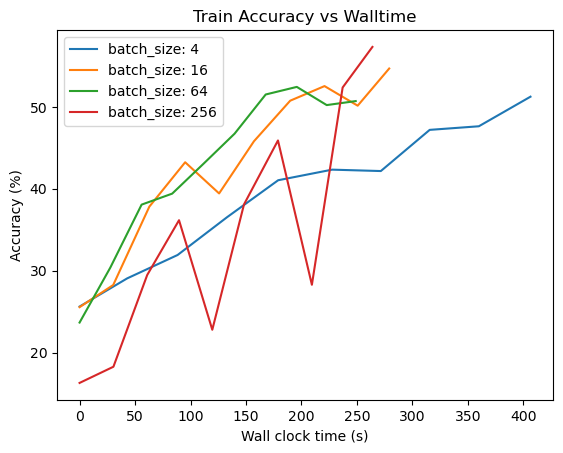


====== Memory Usage for different batch sizes =======
4	: 2918.0 MB
16	: 3622.0 MB
64	: 5270.0 MB
256	: 7818.0 MB


In [31]:
# Plotting scripts
def get_df(batch_size):
    path = ROOT_PATH + f'logs/resnet18__{batch_size}.csv'
    assert os.path.exists(path), f'Memory profile not found for batch size {batch_size}. Have you run run_train({batch_size}) in the above cell?'
    df = pd.read_csv(path)
    # Create a wall time column
    df['walltime'] = df['timestamp'] - df['timestamp'].iloc[0]
    return df

def plot_walltime_acc(batch_sizes):
    plt.figure()
    for bs in batch_sizes:
        df=get_df(bs)
        plt.plot(df['walltime'].to_numpy(), df['accuracy'].to_numpy(), label=f'batch_size: {bs}')
    plt.xlabel('Wall clock time (s)')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Train Accuracy vs Walltime')
    plt.show()

def print_mem_usage(batch_sizes):
    print("\n====== Memory Usage for different batch sizes =======")
    for bs in batch_sizes:
        df=get_df(bs)
        mem_usage = df['memUsage'].iloc[-1]
        print(f'{bs}\t: {mem_usage} MB')

batch_sizes = [4, 16, 64, 256]
plot_walltime_acc(batch_sizes)
print_mem_usage(batch_sizes)

## Questions (answer in written submission)
**3a. What is the memory utilization for different batch sizes (4, 16, 64, 256)? What is the largest batch size you were able to train?**

- Batch size 4: 2918 MB
- Batch size 16: 3622 MB
- Batch size 64: 5270 MB
- Batch size 256: 7818 MB

**3b. Which batch size gave you the highest accuracy at the end of 10 epochs?**

Batch size 256 gave the highest accuracy at the end of 10 epochs.

**3c. Which batch size completed 10 epochs the fastest (least wall clock time)? Why?**

Batch size 256 completed 10 epochs the fastest. This is because larger batch sizes allow for more efficient use of the GPU, as the GPU may spend more time waiting for data to be transferred from CPU to GPU.

**3d. Attach your training accuracy vs wall time plots with your written  submission.**
